In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, qmc
import time

In [2]:
# --- 1. Model Parameters ---
S0 = 100.0       # Initial Stock Price 
K = 100.0        # Strike Price 
r = 0.1          # Risk-free rate 
sigma = 0.1      # Volatility 
T = 1.0          # Maturity 
m_values = 2 ** np.arange(5,11)  # Time discretization steps (Example value) 

# Simulation Parameters
N_powers = np.arange(7, 14) # Powers 7 to 13
N_values = 2**N_powers      # N = 128, ..., 8192 
n_shifts = 32 # Number of random shifts for RQMC error estimation

In [5]:

def asian_call_payoff(u_samples, S0, K, r, sigma, T, m):
    """
    Computes the discounted payoff of an Asian Call Option.
    
    Args:
        u_samples: (N, m) array of Uniform(0,1) samples.
    Returns:
        (N,) array of discounted payoffs.
    """
    N = u_samples.shape[0]
    dt = T / m
    
    # 1. Inverse CDF to get Standard Normal Increments (xi)
    # Note: For very high precision in tails, one might use a custom Moro algorithm,
    # but scipy's ppf is sufficient for Step 1.
    xi = norm.ppf(u_samples) 
    
    # 2. Construct Brownian Motion Path (w)
    # w_ti = sum(xi) * sqrt(dt)
    w = np.cumsum(xi, axis=1) * np.sqrt(dt)
    
    # 3. Calculate Stock Price Path
    # S_t = S0 * exp((r - 0.5*sigma^2)t + sigma*w)
    time_grid = np.arange(1, m + 1) * dt
    S_path = S0 * np.exp((r - 0.5 * sigma**2) * time_grid + sigma * w)
    
    # 4. Asian Option Payoff
    # Average price over the path
    S_avg = np.mean(S_path, axis=1)
    
    # Max(Average - K, 0)
    payoff = np.maximum(S_avg - K, 0)
    
    # 5. Discounting
    return np.exp(-r * T) * payoff


In [9]:




# --- 2. Simulation Loop ---

print(f"{'N':<10} | {'MC Est':<12} | {'MC Err':<12} | {'RQMC Est':<12} | {'RQMC Err':<12}")
print("-" * 70)

for m in m_values:
    mc_errors = []
    rqmc_errors = []
    mc_means = []
    rqmc_means = []

    for N in N_values:
        # --- Crude Monte Carlo ---
        # Generate N random samples in m dimensions
        u_mc = np.random.rand(N, m)
        
        # Evaluate
        Y_mc = asian_call_payoff(u_mc, S0, K, r, sigma, T, m)
        
        # Estimates
        mu_mc = np.mean(Y_mc)
        # Standard Error of the mean
        err_mc = np.std(Y_mc, ddof=1) / np.sqrt(N)
        
        mc_means.append(mu_mc)
        mc_errors.append(err_mc)
        
        # --- Randomized QMC (Sobol) ---
        # We use Scipy's Sobol generator. 
        # To estimate error, we repeat the simulation 'n_shifts' times with different scrambles.
        
        shift_means = []
        
        for _ in range(n_shifts):
            # Create Sobol sampler
            sampler = qmc.Sobol(d=m, scramble=True) 
            # Generate points (must be power of 2 for Sobol balance properties)
            u_rqmc = sampler.random(n=N)
            
            # Evaluate
            Y_rqmc = asian_call_payoff(u_rqmc, S0, K, r, sigma, T, m)
            shift_means.append(np.mean(Y_rqmc))
        
        # RQMC Estimate is the mean of the shifts
        mu_rqmc = np.mean(shift_means)
        # RQMC Error is the standard deviation of the shift means (approx)
        # We use this as a proxy for the integration error.
        err_rqmc = np.std(shift_means, ddof=1)
        
        rqmc_means.append(mu_rqmc)
        rqmc_errors.append(err_rqmc)

        print(f"{N:<10} | {mu_mc:.6f}     | {err_mc:.6f}     | {mu_rqmc:.6f}     | {err_rqmc:.6f}")

N          | MC Est       | MC Err       | RQMC Est     | RQMC Err    
----------------------------------------------------------------------
128        | 5.990258     | 0.448099     | 5.394252     | 0.053650
256        | 5.143642     | 0.325195     | 5.416704     | 0.039549
512        | 5.235171     | 0.205896     | 5.404204     | 0.027662
1024       | 5.408904     | 0.149819     | 5.405008     | 0.016520
2048       | 5.462280     | 0.108103     | 5.409526     | 0.009498
4096       | 5.385385     | 0.075100     | 5.408545     | 0.008372
8192       | 5.398934     | 0.053384     | 5.410488     | 0.004959
128        | 5.110561     | 0.426637     | 5.344253     | 0.100700
256        | 5.251161     | 0.321458     | 5.332486     | 0.048458
512        | 5.510751     | 0.209388     | 5.340007     | 0.031047
1024       | 5.304055     | 0.147153     | 5.328891     | 0.021337
2048       | 5.293112     | 0.106739     | 5.333628     | 0.011178
4096       | 5.310556     | 0.073887     | 5.331595   

7 7


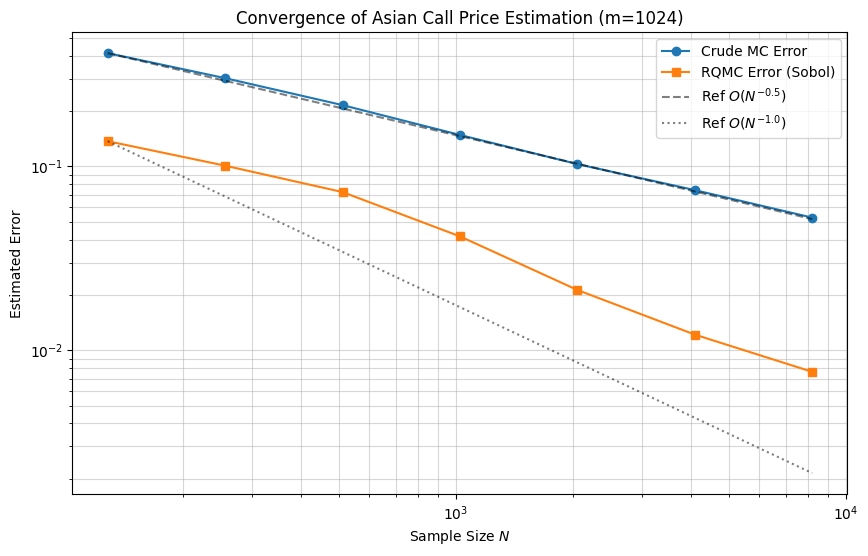

In [10]:

# --- 3. Plotting Convergence ---

plt.figure(figsize=(10, 6))
print(len(mc_errors),len(N_values))

# Plot Errors
plt.loglog(N_values, mc_errors, 'o-', label='Crude MC Error')
plt.loglog(N_values, rqmc_errors, 's-', label='RQMC Error (Sobol)')

# Reference Lines
ref_x = N_values
ref_mc = 1.0 / np.sqrt(ref_x) * mc_errors[0] * np.sqrt(N_values[0]) # Scale to match start
ref_qmc = 1.0 / ref_x * rqmc_errors[0] * N_values[0] # Scale to match start

plt.loglog(ref_x, ref_mc, 'k--', alpha=0.5, label=r'Ref $O(N^{-0.5})$')
plt.loglog(ref_x, ref_qmc, 'k:', alpha=0.5, label=r'Ref $O(N^{-1.0})$')

plt.xlabel('Sample Size $N$')
plt.ylabel('Estimated Error')
plt.title(f'Convergence of Asian Call Price Estimation (m={m})')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()


In [95]:
import numpy as np
import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt



# --- Parametri del Problema ---
S0 = 100.0
K = 100.0
r = 0.1
sigma = 0.1
T = 1.0
m = 2 ** 9  # Time discretization steps (Example value) 
Q_points = 50   # Numero di punti per la quadratura di Gauss (dispari per includere 0)


In [96]:
# --- Funzioni di Utilità ---

def get_gauss_hermite_nodes(n_points):
    """
    Restituisce nodi e pesi per l'integrazione rispetto alla densità Normale Standard.
    La funzione numpy.polynomial.hermite.hermgauss integra rispetto a e^(-x^2).
    Dobbiamo adattarla per 1/sqrt(2pi) * e^(-x^2/2).
    Change of variable: x_std = sqrt(2) * x_herm
    """
    x, w = np.polynomial.hermite.hermgauss(n_points)
    # Adattamento per la normale standard N(0,1)
    nodes = np.sqrt(2) * x
    weights = w / np.sqrt(np.pi)
    return nodes, weights


In [97]:

def generate_paths_hybrid(N, m, method, j_dir, nodes, weights):
    dt = T / m
    
    # 1. Generiamo i campioni per le m-1 dimensioni (tutte tranne j)
    # Dimensione del problema ridotto: m - 1
    if method == 'QMC':
        sampler = qmc.Sobol(d=m-1, scramble=True)
        u_samples = sampler.random_base2(m=int(np.log2(N))) # N deve essere potenza di 2 per Sobol ottimale
        z_rest = stats.norm.ppf(u_samples)
    else: # MC standard
        z_rest = np.random.normal(size=(N, m - 1))
    
    # z_rest ha shape (N, m-1). Dobbiamo inserire la dimensione j.
    # La dimensione j non è un singolo numero, ma un vettore di nodi di quadratura.
    # Per ogni campione MC (riga i), dobbiamo valutare TUTTI i nodi di quadratura k.
    
    # Costruiamo una struttura (N, Q, m) o processiamo in batch.
    # Per chiarezza, costruiamo i percorsi.
    
    # Preparare gli incrementi browniani Z
    # Z avrà shape (N, Q_points, m)
    n_nodes = len(nodes)
    Z = np.zeros((N, n_nodes, m))
    
    # Riempiamo le dimensioni != j
    # Copiamo z_rest per ogni nodo di quadratura (è fisso per un dato campione N)
    # Indici mappa: 0..j-1 vanno in 0..j-1; j..m-2 vanno in j+1..m-1
    if j_dir > 0:
        Z[:, :, :j_dir] = z_rest[:, :j_dir][:, np.newaxis, :]
    if j_dir < m - 1:
        Z[:, :, j_dir+1:] = z_rest[:, j_dir:][:, np.newaxis, :]
        
    # Riempiamo la dimensione j con i nodi di Gauss
    # Questo varia lungo l'asse 1 (nodi), ma è costante lungo l'asse 0 (campioni N)
    Z[:, :, j_dir] = nodes[np.newaxis, :] # Broadcasting
    
    # 2. Costruzione del percorso (Random Walk Standard)
    # W_ti = somma cumulativa di sqrt(dt) * Z
    W = np.cumsum(Z * np.sqrt(dt), axis=2)
    
    # 3. Calcolo Stock Prices S_ti
    # S_t = S0 * exp( (r - 0.5*sigma^2)t + sigma * W_t )
    times = np.linspace(dt, T, m)
    drift = (r - 0.5 * sigma**2) * times
    
    # Drift shape (m,), W shape (N, Q, m)
    S = S0 * np.exp(drift[np.newaxis, np.newaxis, :] + sigma * W)
    
    # 4. Media Asiatica A = (1/m) sum S_ti
    A = np.mean(S, axis=2) # Shape (N, Q)
    
    return A


In [98]:

def pricing_hybrid(N, method='MC'):
    # Setup Quadratura per la direzione j=0 (la più importante)
    j_dir = 0 
    nodes, q_weights = get_gauss_hermite_nodes(Q_points)
    
    # Genera le medie aritmetiche A di shape (N, Q)
    # A[i, k] è la media dello stock per il campione MC i-esimo e il nodo Gauss k-esimo
    A = generate_paths_hybrid(N, m, method, j_dir, nodes, q_weights)
    
    # Calcolo Payoff
    # Call: max(A - K, 0)
    payoff_call_matrix = np.maximum(A - K, 0)
    
    # Digital: 1 se A > K
    payoff_dig_matrix = (A > K).astype(float)
    
    # Integrazione sulla dimensione j (Quadratura)
    # Somma pesata sulle colonne (asse 1)
    # Risultato intermedio: vettore di dimensione N (valori pre-integrati)
    v_call_pre = np.dot(payoff_call_matrix, q_weights)
    v_dig_pre = np.dot(payoff_dig_matrix, q_weights)
    
    # Integrazione sulle dimensioni restanti (Media MC/QMC)
    price_call = np.mean(v_call_pre) * np.exp(-r*T)
    price_dig = np.mean(v_dig_pre) * np.exp(-r*T)
    
    return price_call, price_dig


In [99]:

# --- Simulazione e Plotting ---

# Valori di riferimento (ottenuti con N alto QMC puro o pre-integration analitica)
# Usiamo un run molto lungo di questo stesso metodo come proxy o valori noti
ref_call = 5.86  # Valore indicativo approx
ref_dig = 0.52   # Valore indicativo approx

N_powers = np.arange(7, 14) # Da 2^7 a 2^13
N_values = 2**N_powers

err_call_mc, err_call_qmc = [], []
err_dig_mc, err_dig_qmc = [], []

# Calcoliamo una "Ground Truth" interna con N molto alto (QMC)
print("Calcolo Reference value...")
ref_call_high, ref_dig_high = pricing_hybrid(2**15, 'QMC')
print(f"Ref Call: {ref_call_high:.5f}, Ref Dig: {ref_dig_high:.5f}")

print("\nInizio Simulazione...")
for n in N_values:
    # MC Hybrid
    c_mc, d_mc = pricing_hybrid(n, 'MC')
    err_call_mc.append(abs(c_mc - ref_call_high))
    err_dig_mc.append(abs(d_mc - ref_dig_high))
    
    # QMC Hybrid
    c_qmc, d_qmc = pricing_hybrid(n, 'QMC')
    err_call_qmc.append(abs(c_qmc - ref_call_high))
    err_dig_qmc.append(abs(d_qmc - ref_dig_high))


Calcolo Reference value...
Ref Call: 5.26091, Ref Dig: 0.72067

Inizio Simulazione...


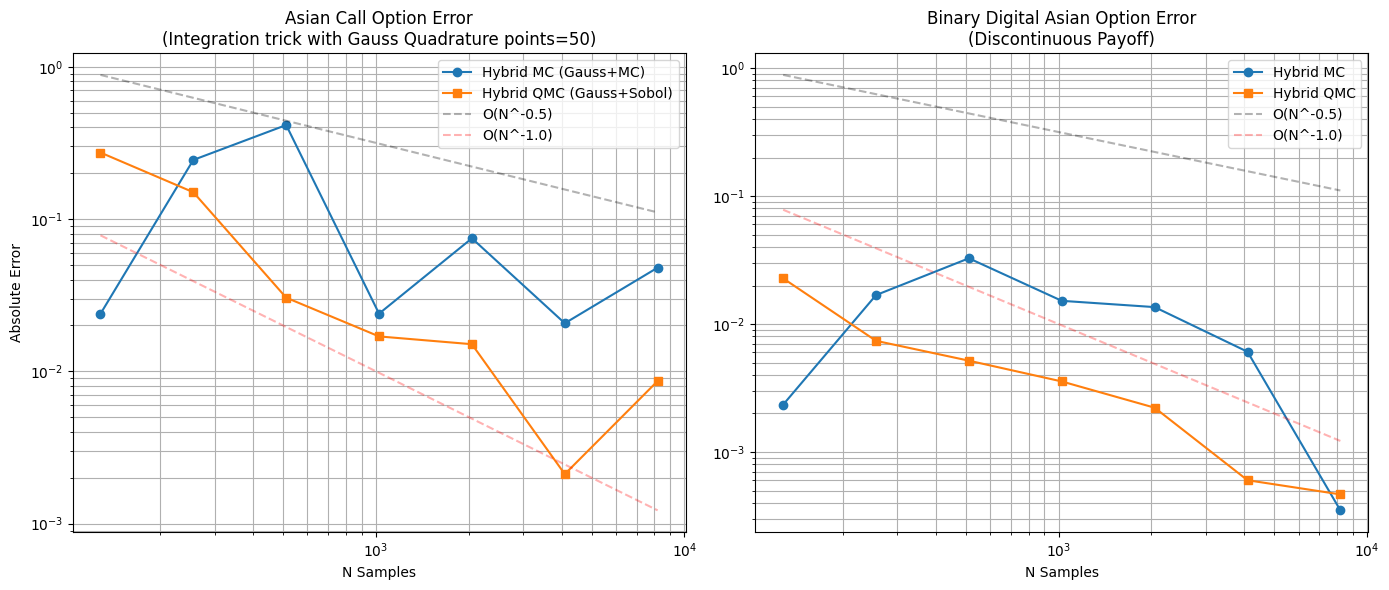

In [100]:

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Call Option
ax[0].loglog(N_values, err_call_mc, 'o-', label='Hybrid MC (Gauss+MC)')
ax[0].loglog(N_values, err_call_qmc, 's-', label='Hybrid QMC (Gauss+Sobol)')
ax[0].loglog(N_values, 10/np.sqrt(N_values), 'k--', alpha=0.3, label='O(N^-0.5)')
ax[0].loglog(N_values, 10/N_values, 'r--', alpha=0.3, label='O(N^-1.0)')
ax[0].set_title(f'Asian Call Option Error\n(Integration trick with Gauss Quadrature points={Q_points})')
ax[0].set_xlabel('N Samples')
ax[0].set_ylabel('Absolute Error')
ax[0].legend()
ax[0].grid(True, which="both", ls="-")

# Plot Digital Option
ax[1].loglog(N_values, err_dig_mc, 'o-', label='Hybrid MC')
ax[1].loglog(N_values, err_dig_qmc, 's-', label='Hybrid QMC')
ax[1].loglog(N_values, 10/np.sqrt(N_values), 'k--', alpha=0.3, label='O(N^-0.5)')
ax[1].loglog(N_values, 10/N_values, 'r--', alpha=0.3, label='O(N^-1.0)')
ax[1].set_title(f'Binary Digital Asian Option Error\n(Discontinuous Payoff)')
ax[1].set_xlabel('N Samples')
ax[1].legend()
ax[1].grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()